## Ejemplo simple: modelo 2D

Imaginamos que ciertos puntos representan un manifold en el espacio latente. El objetivo es entrenar un generador que pueda producir cualquier punto de esa distribución (una parábola).

### Generación de muestras cuadráticas (x, x²)

Comenzando con una distribución aleatoria

El **Generador** y el **Discriminador** son entrenados para descubrir el manifold latente:

- Puntos rojos: aprobados por el Discriminador
- Generador puede generar puntos arbitrarios (azul), pero el objetivo es que genere puntos rojos (válidos)

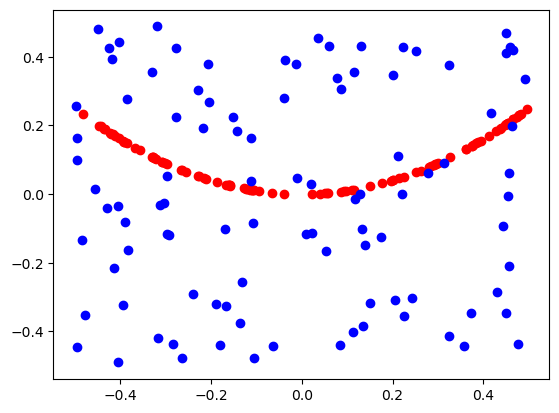

In [1]:
from numpy.random import rand
from numpy import hstack
from matplotlib import pyplot
import numpy as np

# Generar muestras cuadráticas
def generate_samples(n=100):
    # Entradas aleatorias en [-0.5, 0.5]
    X1 = rand(n) - 0.5
    # Salidas cuadráticas
    X2 = X1 * X1
    # Apilar
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    return hstack((X1, X2))

# Muestras reales (rojas)
data = generate_samples()
# Muestras aleatorias (azules)
data2 = np.random.uniform(-0.5, 0.5, size=(100, 2))

# Graficar
pyplot.scatter(data[:, 0], data[:, 1], color='red')
pyplot.scatter(data2[:, 0], data2[:, 1], color='blue')
pyplot.show()

### Uso de espacio latente de dimensión 5

- **Discriminador**: toma dos valores reales y devuelve la probabilidad de que la muestra sea real o falsa.
  - 2 entradas (bidimensional)
  - 1 salida (V/F)
- **Generador**: recibe un vector en el espacio latente (dim=5) y produce dos valores reales.
  - 5 entradas (espacio latente)
  - 2 salidas (bidimensional)


In [2]:
from numpy.random import randn
from numpy import zeros

# Generar puntos en el espacio latente para el generador
def generate_latent_points(latent_dim, n):
    x_input = randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# Usar el generador para crear muestras falsas
def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input)
    y = zeros((n, 1))
    return X, y

### Implementación simple **Discriminador** y **Generador**

In [ ]:
# Discriminador: entrada 2 reales, salida clasificación binaria
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Generador: entrada vector latente, salida 2 reales (x, x^2)
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

### Juntando las dos redes: **GAN**

In [ ]:
# GAN combinado: conecta generador y discriminador, solo se entrena el generador
def define_gan(generator, discriminator):
    discriminator.trainable = False  # congelar discriminador
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

### Entrenamiento Min-Max

Durante el entrenamiento:
- Se congela el discriminador cuando se entrena el generador (`discriminator.trainable = False`).
- Se actualizan los pesos del generador para intentar engañar al discriminador.
- Luego se actualiza el discriminador con nuevas muestras.

- Los pesos del discriminador se congelan para evitar que el generador lo sobreentrene.
- El generador se mejora a partir de la retroalimentación del discriminador.
- Esta dinámica define un juego de suma cero (`zero-sum game`).


- Se alterna el entrenamiento del discriminador y del generador.
- El discriminador aprende a distinguir entre muestras reales y falsas.
- El generador mejora al intentar engañar al discriminador.

Se minimiza la siguiente función de pérdida:

$$
L_D = -\frac{1}{2} \mathbb{E}_{x \sim p_{\text{data}}}[\log D(x)] - \frac{1}{2} \mathbb{E}_{z \sim p_z}[\log (1 - D(G(z)))]
$$

$$
L_G = -\frac{1}{2} \mathbb{E}_{z \sim p_z}[\log D(G(z))]
$$

$$
L_{\text{GAN}} = \min_G \max_D (L_D + L_G)
$$

Donde:

- \( D(x) \) es la probabilidad que el discriminador asigna a una muestra real.
- \( G(z) \) es la muestra generada por el generador a partir de una variable latente \( z \).
- \( p_{\text{data}} \) es la distribución real de los datos.
- \( p_z \) es la distribución del espacio latente.


In [ ]:
# Entrenamiento GAN completo
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=400):
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        # muestras reales
        X_real, y_real = generate_samples(half_batch), ones((half_batch, 1))
        # muestras falsas
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # entrenar discriminador
        d_model.train_on_batch(X_real, y_real)
        d_model.train_on_batch(X_fake, y_fake)
        # entrenar generador (a través del GAN)
        x_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1))  # el generador quiere que el discriminador diga "real"
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluar
        if (i+1) % n_eval == 0:
            print(f">Epoch {i+1} evaluado")

### Resultado
Después de muchos epochs, las muestras generadas son prácticamente indistinguibles de las reales.